In [6]:
import os
print(os.getcwd())

/rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/inference


In [10]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Find the CellViT directory
cellvit_dir = current_dir
while os.path.basename(cellvit_dir) != 'CellViT':
    cellvit_dir = os.path.dirname(cellvit_dir)
    if cellvit_dir == os.path.dirname(cellvit_dir):  # reached root directory
        raise Exception("CellViT directory not found in the path")

# Add the CellViT directory to the Python path
sys.path.insert(0, cellvit_dir)

print(f"Added {cellvit_dir} to Python path")

Added /rsrch5/home/plm/yshokrollahi/CellViT to Python path


In [20]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [21]:
# -*- coding: utf-8 -*-
# CellViT Inference Method for Patch-Wise Inference on a test set
# Without merging WSI
#
# Aim is to calculate metrics as defined for the PanNuke dataset
#
# @ Fabian Hörst, fabian.hoerst@uk-essen.de
# Institute for Artifical Intelligence in Medicine,
# University Medicine Essen

import argparse
import inspect
import os
import sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
parentdir = os.path.dirname(parentdir)
sys.path.insert(0, parentdir)

from base_ml.base_experiment import BaseExperiment

BaseExperiment.seed_run(1232)

import json
from pathlib import Path
from typing import List, Tuple, Union

import albumentations as A
import numpy as np
import torch
import torch.nn.functional as F
import tqdm
import yaml
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from skimage.color import rgba2rgb
from sklearn.metrics import accuracy_score
from tabulate import tabulate
from torch.utils.data import DataLoader
from torchmetrics.functional import dice
from torchmetrics.functional.classification import binary_jaccard_index
from torchvision import transforms

from cell_segmentation.datasets.dataset_coordinator import select_dataset
from models.segmentation.cell_segmentation.cellvit import DataclassHVStorage
from cell_segmentation.utils.metrics import (
    cell_detection_scores,
    cell_type_detection_scores,
    get_fast_pq,
    remap_label,
    binarize,
)
from cell_segmentation.utils.post_proc_cellvit import calculate_instances
from cell_segmentation.utils.tools import cropping_center, pair_coordinates
from models.segmentation.cell_segmentation.cellvit import (
    CellViT,
    CellViT256,
    CellViTSAM,
)
from models.segmentation.cell_segmentation.cellvit_shared import (
    CellViT256Shared,
    CellViTSAMShared,
    CellViTShared,
)
from utils.logger import Logger
print("import completed")

import completed


In [22]:



class InferenceCellViT:
    def __init__(
        self,
        run_dir: Union[Path, str],
        gpu: int,
        magnification: int = 40,
        checkpoint_name: str = "model_best.pth",
    ) -> None:
        """Inference for HoverNet

        Args:
            run_dir (Union[Path, str]): logging directory with checkpoints and configs
            gpu (int): CUDA GPU device to use for inference
            magnification (int, optional): Dataset magnification. Defaults to 40.
            checkpoint_name (str, optional): Select name of the model to load. Defaults to model_best.pth
        """
        self.run_dir = Path(run_dir)
        self.device = f"cuda:{gpu}"
        self.run_conf: dict = None
        self.logger: Logger = None
        self.magnification = magnification
        self.checkpoint_name = checkpoint_name

        self.__load_run_conf()

        self.__load_dataset_setup(dataset_path=self.run_conf["data"]["dataset_path"])
        self.__instantiate_logger()
        self.__check_eval_model()
        self.__setup_amp()

        self.logger.info(f"Loaded run: {run_dir}")
        self.num_classes = self.run_conf["data"]["num_nuclei_classes"]

    def __load_run_conf(self) -> None:
        """Load the config.yaml file with the run setup

        Be careful with loading and usage, since original None values in the run configuration are not stored when dumped to yaml file.
        If you want to check if a key is not defined, first check if the key does exists in the dict.
        """
        with open((self.run_dir / "config.yaml").resolve(), "r") as run_config_file:
            yaml_config = yaml.safe_load(run_config_file)
            self.run_conf = dict(yaml_config)

    def __load_dataset_setup(self, dataset_path: Union[Path, str]) -> None:
        """Load the configuration of the cell segmentation dataset.

        The dataset must have a dataset_config.yaml file in their dataset path with the following entries:
            * tissue_types: describing the present tissue types with corresponding integer
            * nuclei_types: describing the present nuclei types with corresponding integer

        Args:
            dataset_path (Union[Path, str]): Path to dataset folder
        """
        dataset_config_path = Path(dataset_path) / "dataset_config.yaml"
        with open(dataset_config_path, "r") as dataset_config_file:
            yaml_config = yaml.safe_load(dataset_config_file)
            self.dataset_config = dict(yaml_config)

    def __instantiate_logger(self) -> None:
        """Instantiate logger

        Logger is using no formatters. Logs are stored in the run directory under the filename: inference.log
        """
        logger = Logger(
            level=self.run_conf["logging"]["level"].upper(),
            log_dir=Path(self.run_dir).resolve(),
            comment="inference",
            use_timestamp=False,
            formatter="%(message)s",
        )
        self.logger = logger.create_logger()

    def __check_eval_model(self) -> None:
        """Check if there is a best model pytorch file"""
        assert (self.run_dir / "checkpoints" / self.checkpoint_name).is_file()

    def __setup_amp(self) -> None:
        """Setup automated mixed precision (amp) for inference."""
        self.mixed_precision = self.run_conf["training"].get("mixed_precision", False)

    def get_model(
        self, model_type: str
    ) -> Union[
        CellViT,
        CellViTShared,
        CellViT256,
        CellViT256Shared,
        CellViTSAM,
        CellViTSAMShared,
    ]:
        """Return the trained model for inference

        Args:
            model_type (str): Name of the model. Must either be one of:
                CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared

        Returns:
            Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]: Model
        """
        implemented_models = [
            "CellViT",
            "CellViTShared",
            "CellViT256",
            "CellViT256Shared",
            "CellViTSAM",
            "CellViTSAMShared",
        ]
        if model_type not in implemented_models:
            raise NotImplementedError(
                f"Unknown model type. Please select one of {implemented_models}"
            )
        if model_type in ["CellViT", "CellViTShared"]:
            if model_type == "CellViT":
                model_class = CellViT
            elif model_type == "CellViTShared":
                model_class = CellViTShared
            model = model_class(
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                embed_dim=self.run_conf["model"]["embed_dim"],
                input_channels=self.run_conf["model"].get("input_channels", 3),
                depth=self.run_conf["model"]["depth"],
                num_heads=self.run_conf["model"]["num_heads"],
                extract_layers=self.run_conf["model"]["extract_layers"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )

        elif model_type in ["CellViT256", "CellViT256Shared"]:
            if model_type == "CellViT256":
                model_class = CellViT256
            elif model_type == "CellViT256Shared":
                model_class = CellViT256Shared
            model = model_class(
                model256_path=None,
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )
        elif model_type in ["CellViTSAM", "CellViTSAMShared"]:
            if model_type == "CellViTSAM":
                model_class = CellViTSAM
            elif model_type == "CellViTSAMShared":
                model_class = CellViTSAMShared
            model = model_class(
                model_path=None,
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                vit_structure=self.run_conf["model"]["backbone"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )
        return model

    def setup_patch_inference(
        self, test_folds: List[int] = None
    ) -> tuple[
        Union[
            CellViT,
            CellViTShared,
            CellViT256,
            CellViT256Shared,
            CellViTSAM,
            CellViTSAMShared,
        ],
        DataLoader,
        dict,
    ]:
        """Setup patch inference by defining a patch-wise datalaoder and loading the model checkpoint

        Args:
            test_folds (List[int], optional): Test fold to use. Otherwise defined folds from config.yaml (in run_dir) are loaded. Defaults to None.

        Returns:
            tuple[Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared], DataLoader, dict]:
                Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]: Best model loaded form checkpoint
                DataLoader: Inference DataLoader
                dict: Dataset configuration. Keys are:
                    * "tissue_types": describing the present tissue types with corresponding integer
                    * "nuclei_types": describing the present nuclei types with corresponding integer

        """
        # get model for inference
        checkpoint = torch.load(
            self.run_dir / "checkpoints" / self.checkpoint_name, map_location="cpu"
        )
        model = self.get_model(model_type=checkpoint["arch"])
        self.logger.info(
            f"Loading best model from {str(self.run_dir / 'checkpoints' / self.checkpoint_name)}"
        )
        self.logger.info(model.load_state_dict(checkpoint["model_state_dict"]))

        # get dataset
        if test_folds is None:
            if "test_folds" in self.run_conf["data"]:
                if self.run_conf["data"]["test_folds"] is None:
                    self.logger.info(
                        "There was no test set provided. We now use the validation dataset for testing"
                    )
                    self.run_conf["data"]["test_folds"] = self.run_conf["data"][
                        "val_folds"
                    ]
            else:
                self.logger.info(
                    "There was no test set provided. We now use the validation dataset for testing"
                )
                self.run_conf["data"]["test_folds"] = self.run_conf["data"]["val_folds"]
        else:
            self.run_conf["data"]["test_folds"] = self.run_conf["data"]["val_folds"]
        self.logger.info(
            f"Performing Inference on test set: {self.run_conf['data']['test_folds']}"
        )

        transform_settings = self.run_conf["transformations"]
        if "normalize" in transform_settings:
            mean = transform_settings["normalize"].get("mean", (0.5, 0.5, 0.5))
            std = transform_settings["normalize"].get("std", (0.5, 0.5, 0.5))
        else:
            mean = (0.5, 0.5, 0.5)
            std = (0.5, 0.5, 0.5)
        transforms = A.Compose([A.Normalize(mean=mean, std=std)])

        inference_dataset = select_dataset(
            dataset_name=self.run_conf["data"]["dataset"],
            split="test",
            dataset_config=self.run_conf["data"],
            transforms=transforms,
        )

        inference_dataloader = DataLoader(
            inference_dataset,
            batch_size=128,
            num_workers=12,
            pin_memory=False,
            shuffle=False,
        )

        return model, inference_dataloader, self.dataset_config

    def run_patch_inference(
        self,
        model: Union[
            CellViT,
            CellViTShared,
            CellViT256,
            CellViT256Shared,
            CellViTSAM,
            CellViTSAMShared,
        ],
        inference_dataloader: DataLoader,
        dataset_config: dict,
        generate_plots: bool = False,
    ) -> None:
        """Run Patch inference with given setup

        Args:
            model (Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]): Model to use for inference
            inference_dataloader (DataLoader): Inference Dataloader. Must return a batch with the following structure:
                * Images (torch.Tensor)
                * Masks (dict)
                * Tissue types as str
                * Image name as str
            dataset_config (dict): Dataset configuration. Required keys are:
                    * "tissue_types": describing the present tissue types with corresponding integer
                    * "nuclei_types": describing the present nuclei types with corresponding integer
            generate_plots (bool, optional): If inference plots should be generated. Defaults to False.
        """
        # put model in eval mode
        model.to(device=self.device)
        model.eval()

In [23]:

class InferenceCellViT:
    def __init__(
        self,
        run_dir: Union[Path, str],
        gpu: int,
        magnification: int = 40,
        checkpoint_name: str = "model_best.pth",
    ) -> None:
        """Inference for HoverNet

        Args:
            run_dir (Union[Path, str]): logging directory with checkpoints and configs
            gpu (int): CUDA GPU device to use for inference
            magnification (int, optional): Dataset magnification. Defaults to 40.
            checkpoint_name (str, optional): Select name of the model to load. Defaults to model_best.pth
        """
        self.run_dir = Path(run_dir)
        self.device = f"cuda:{gpu}"
        self.run_conf: dict = None
        self.logger: Logger = None
        self.magnification = magnification
        self.checkpoint_name = checkpoint_name

        self.__load_run_conf()

        self.__load_dataset_setup(dataset_path=self.run_conf["data"]["dataset_path"])
        self.__instantiate_logger()
        self.__check_eval_model()
        self.__setup_amp()

        self.logger.info(f"Loaded run: {run_dir}")
        self.num_classes = self.run_conf["data"]["num_nuclei_classes"]

    def __load_run_conf(self) -> None:
        """Load the config.yaml file with the run setup

        Be careful with loading and usage, since original None values in the run configuration are not stored when dumped to yaml file.
        If you want to check if a key is not defined, first check if the key does exists in the dict.
        """
        with open((self.run_dir / "config.yaml").resolve(), "r") as run_config_file:
            yaml_config = yaml.safe_load(run_config_file)
            self.run_conf = dict(yaml_config)

    def __load_dataset_setup(self, dataset_path: Union[Path, str]) -> None:
        """Load the configuration of the cell segmentation dataset.

        The dataset must have a dataset_config.yaml file in their dataset path with the following entries:
            * tissue_types: describing the present tissue types with corresponding integer
            * nuclei_types: describing the present nuclei types with corresponding integer

        Args:
            dataset_path (Union[Path, str]): Path to dataset folder
        """
        dataset_config_path = Path(dataset_path) / "dataset_config.yaml"
        with open(dataset_config_path, "r") as dataset_config_file:
            yaml_config = yaml.safe_load(dataset_config_file)
            self.dataset_config = dict(yaml_config)

    def __instantiate_logger(self) -> None:
        """Instantiate logger

        Logger is using no formatters. Logs are stored in the run directory under the filename: inference.log
        """
        logger = Logger(
            level=self.run_conf["logging"]["level"].upper(),
            log_dir=Path(self.run_dir).resolve(),
            comment="inference",
            use_timestamp=False,
            formatter="%(message)s",
        )
        self.logger = logger.create_logger()

    def __check_eval_model(self) -> None:
        """Check if there is a best model pytorch file"""
        assert (self.run_dir / "checkpoints" / self.checkpoint_name).is_file()

    def __setup_amp(self) -> None:
        """Setup automated mixed precision (amp) for inference."""
        self.mixed_precision = self.run_conf["training"].get("mixed_precision", False)

    def get_model(
        self, model_type: str
    ) -> Union[
        CellViT,
        CellViTShared,
        CellViT256,
        CellViT256Shared,
        CellViTSAM,
        CellViTSAMShared,
    ]:
        """Return the trained model for inference

        Args:
            model_type (str): Name of the model. Must either be one of:
                CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared

        Returns:
            Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]: Model
        """
        implemented_models = [
            "CellViT",
            "CellViTShared",
            "CellViT256",
            "CellViT256Shared",
            "CellViTSAM",
            "CellViTSAMShared",
        ]
        if model_type not in implemented_models:
            raise NotImplementedError(
                f"Unknown model type. Please select one of {implemented_models}"
            )
        if model_type in ["CellViT", "CellViTShared"]:
            if model_type == "CellViT":
                model_class = CellViT
            elif model_type == "CellViTShared":
                model_class = CellViTShared
            model = model_class(
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                embed_dim=self.run_conf["model"]["embed_dim"],
                input_channels=self.run_conf["model"].get("input_channels", 3),
                depth=self.run_conf["model"]["depth"],
                num_heads=self.run_conf["model"]["num_heads"],
                extract_layers=self.run_conf["model"]["extract_layers"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )

        elif model_type in ["CellViT256", "CellViT256Shared"]:
            if model_type == "CellViT256":
                model_class = CellViT256
            elif model_type == "CellViT256Shared":
                model_class = CellViT256Shared
            model = model_class(
                model256_path=None,
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )
        elif model_type in ["CellViTSAM", "CellViTSAMShared"]:
            if model_type == "CellViTSAM":
                model_class = CellViTSAM
            elif model_type == "CellViTSAMShared":
                model_class = CellViTSAMShared
            model = model_class(
                model_path=None,
                num_nuclei_classes=self.run_conf["data"]["num_nuclei_classes"],
                num_tissue_classes=self.run_conf["data"]["num_tissue_classes"],
                vit_structure=self.run_conf["model"]["backbone"],
                regression_loss=self.run_conf["model"].get("regression_loss", False),
            )
        return model

    def setup_patch_inference(
        self, test_folds: List[int] = None
    ) -> tuple[
        Union[
            CellViT,
            CellViTShared,
            CellViT256,
            CellViT256Shared,
            CellViTSAM,
            CellViTSAMShared,
        ],
        DataLoader,
        dict,
    ]:
        """Setup patch inference by defining a patch-wise datalaoder and loading the model checkpoint

        Args:
            test_folds (List[int], optional): Test fold to use. Otherwise defined folds from config.yaml (in run_dir) are loaded. Defaults to None.

        Returns:
            tuple[Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared], DataLoader, dict]:
                Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]: Best model loaded form checkpoint
                DataLoader: Inference DataLoader
                dict: Dataset configuration. Keys are:
                    * "tissue_types": describing the present tissue types with corresponding integer
                    * "nuclei_types": describing the present nuclei types with corresponding integer

        """
        # get model for inference
        checkpoint = torch.load(
            self.run_dir / "checkpoints" / self.checkpoint_name, map_location="cpu"
        )
        model = self.get_model(model_type=checkpoint["arch"])
        self.logger.info(
            f"Loading best model from {str(self.run_dir / 'checkpoints' / self.checkpoint_name)}"
        )
        self.logger.info(model.load_state_dict(checkpoint["model_state_dict"]))

        # get dataset
        if test_folds is None:
            if "test_folds" in self.run_conf["data"]:
                if self.run_conf["data"]["test_folds"] is None:
                    self.logger.info(
                        "There was no test set provided. We now use the validation dataset for testing"
                    )
                    self.run_conf["data"]["test_folds"] = self.run_conf["data"][
                        "val_folds"
                    ]
            else:
                self.logger.info(
                    "There was no test set provided. We now use the validation dataset for testing"
                )
                self.run_conf["data"]["test_folds"] = self.run_conf["data"]["val_folds"]
        else:
            self.run_conf["data"]["test_folds"] = self.run_conf["data"]["val_folds"]
        self.logger.info(
            f"Performing Inference on test set: {self.run_conf['data']['test_folds']}"
        )

        transform_settings = self.run_conf["transformations"]
        if "normalize" in transform_settings:
            mean = transform_settings["normalize"].get("mean", (0.5, 0.5, 0.5))
            std = transform_settings["normalize"].get("std", (0.5, 0.5, 0.5))
        else:
            mean = (0.5, 0.5, 0.5)
            std = (0.5, 0.5, 0.5)
        transforms = A.Compose([A.Normalize(mean=mean, std=std)])

        inference_dataset = select_dataset(
            dataset_name=self.run_conf["data"]["dataset"],
            split="test",
            dataset_config=self.run_conf["data"],
            transforms=transforms,
        )

        inference_dataloader = DataLoader(
            inference_dataset,
            batch_size=128,
            num_workers=12,
            pin_memory=False,
            shuffle=False,
        )

        return model, inference_dataloader, self.dataset_config

    def run_patch_inference(
        self,
        model: Union[
            CellViT,
            CellViTShared,
            CellViT256,
            CellViT256Shared,
            CellViTSAM,
            CellViTSAMShared,
        ],
        inference_dataloader: DataLoader,
        dataset_config: dict,
        generate_plots: bool = False,
    ) -> None:
        """Run Patch inference with given setup

        Args:
            model (Union[CellViT, CellViTShared, CellViT256, CellViT256Shared, CellViTSAM, CellViTSAMShared]): Model to use for inference
            inference_dataloader (DataLoader): Inference Dataloader. Must return a batch with the following structure:
                * Images (torch.Tensor)
                * Masks (dict)
                * Tissue types as str
                * Image name as str
            dataset_config (dict): Dataset configuration. Required keys are:
                    * "tissue_types": describing the present tissue types with corresponding integer
                    * "nuclei_types": describing the present nuclei types with corresponding integer
            generate_plots (bool, optional): If inference plots should be generated. Defaults to False.
        """
        # put model in eval mode
        model.to(device=self.device)
        model.eval()

        # setup score tracker
        image_names = []  # image names as str
        binary_dice_scores = []  # binary dice scores per image
        binary_jaccard_scores = []  # binary jaccard scores per image
        pq_scores = []  # pq-scores per image
        dq_scores = []  # dq-scores per image
        sq_scores = []  # sq-scores per image
        cell_type_pq_scores = []  # pq-scores per cell type and image
        cell_type_dq_scores = []  # dq-scores per cell type and image
        cell_type_sq_scores = []  # sq-scores per cell type and image
        tissue_pred = []  # tissue predictions for each image
        tissue_gt = []  # ground truth tissue image class
        tissue_types_inf = []  # string repr of ground truth tissue image class

        paired_all_global = []  # unique matched index pair
        unpaired_true_all_global = (
            []
        )  # the index must exist in `true_inst_type_all` and unique
        unpaired_pred_all_global = (
            []
        )  # the index must exist in `pred_inst_type_all` and unique
        true_inst_type_all_global = []  # each index is 1 independent data point
        pred_inst_type_all_global = []  # each index is 1 independent data point

        # for detections scores
        true_idx_offset = 0
        pred_idx_offset = 0

        inference_loop = tqdm.tqdm(
            enumerate(inference_dataloader), total=len(inference_dataloader)
        )

        with torch.no_grad():
            for batch_idx, batch in inference_loop:
                batch_metrics = self.inference_step(
                    model, batch, generate_plots=generate_plots
                )
                # unpack batch_metrics
                image_names = image_names + batch_metrics["image_names"]

                # dice scores
                binary_dice_scores = (
                    binary_dice_scores + batch_metrics["binary_dice_scores"]
                )
                binary_jaccard_scores = (
                    binary_jaccard_scores + batch_metrics["binary_jaccard_scores"]
                )

                # pq scores
                pq_scores = pq_scores + batch_metrics["pq_scores"]
                dq_scores = dq_scores + batch_metrics["dq_scores"]
                sq_scores = sq_scores + batch_metrics["sq_scores"]
                tissue_types_inf = tissue_types_inf + batch_metrics["tissue_types"]
                cell_type_pq_scores = (
                    cell_type_pq_scores + batch_metrics["cell_type_pq_scores"]
                )
                cell_type_dq_scores = (
                    cell_type_dq_scores + batch_metrics["cell_type_dq_scores"]
                )
                cell_type_sq_scores = (
                    cell_type_sq_scores + batch_metrics["cell_type_sq_scores"]
                )
                tissue_pred.append(batch_metrics["tissue_pred"])
                tissue_gt.append(batch_metrics["tissue_gt"])

                # detection scores
                true_idx_offset = (
                    true_idx_offset + true_inst_type_all_global[-1].shape[0]
                    if batch_idx != 0
                    else 0
                )
                pred_idx_offset = (
                    pred_idx_offset + pred_inst_type_all_global[-1].shape[0]
                    if batch_idx != 0
                    else 0
                )
                true_inst_type_all_global.append(batch_metrics["true_inst_type_all"])
                pred_inst_type_all_global.append(batch_metrics["pred_inst_type_all"])
                # increment the pairing index statistic
                batch_metrics["paired_all"][:, 0] += true_idx_offset
                batch_metrics["paired_all"][:, 1] += pred_idx_offset
                paired_all_global.append(batch_metrics["paired_all"])

                batch_metrics["unpaired_true_all"] += true_idx_offset
                batch_metrics["unpaired_pred_all"] += pred_idx_offset
                unpaired_true_all_global.append(batch_metrics["unpaired_true_all"])
                unpaired_pred_all_global.append(batch_metrics["unpaired_pred_all"])

        # assemble batches to datasets (global)
        tissue_types_inf = [t.lower() for t in tissue_types_inf]

        paired_all = np.concatenate(paired_all_global, axis=0)
        unpaired_true_all = np.concatenate(unpaired_true_all_global, axis=0)
        unpaired_pred_all = np.concatenate(unpaired_pred_all_global, axis=0)
        true_inst_type_all = np.concatenate(true_inst_type_all_global, axis=0)
        pred_inst_type_all = np.concatenate(pred_inst_type_all_global, axis=0)
        paired_true_type = true_inst_type_all[paired_all[:, 0]]
        paired_pred_type = pred_inst_type_all[paired_all[:, 1]]
        unpaired_true_type = true_inst_type_all[unpaired_true_all]
        unpaired_pred_type = pred_inst_type_all[unpaired_pred_all]

        binary_dice_scores = np.array(binary_dice_scores)
        binary_jaccard_scores = np.array(binary_jaccard_scores)
        pq_scores = np.array(pq_scores)
        dq_scores = np.array(dq_scores)
        sq_scores = np.array(sq_scores)

        tissue_detection_accuracy = accuracy_score(
            y_true=np.concatenate(tissue_gt), y_pred=np.concatenate(tissue_pred)
        )
        f1_d, prec_d, rec_d = cell_detection_scores(
            paired_true=paired_true_type,
            paired_pred=paired_pred_type,
            unpaired_true=unpaired_true_type,
            unpaired_pred=unpaired_pred_type,
        )
        dataset_metrics = {
            "Binary-Cell-Dice-Mean": float(np.nanmean(binary_dice_scores)),
            "Binary-Cell-Jacard-Mean": float(np.nanmean(binary_jaccard_scores)),
            "Tissue-Multiclass-Accuracy": tissue_detection_accuracy,
            "bPQ": float(np.nanmean(pq_scores)),
            "bDQ": float(np.nanmean(dq_scores)),
            "bSQ": float(np.nanmean(sq_scores)),
            "mPQ": float(np.nanmean([np.nanmean(pq) for pq in cell_type_pq_scores])),
            "mDQ": float(np.nanmean([np.nanmean(dq) for dq in cell_type_dq_scores])),
            "mSQ": float(np.nanmean([np.nanmean(sq) for sq in cell_type_sq_scores])),
            "f1_detection": float(f1_d),
            "precision_detection": float(prec_d),
            "recall_detection": float(rec_d),
        }

        # calculate tissue metrics
        tissue_types = dataset_config["tissue_types"]
        tissue_metrics = {}
        for tissue in tissue_types.keys():
            tissue = tissue.lower()
            tissue_ids = np.where(np.asarray(tissue_types_inf) == tissue)
            tissue_metrics[f"{tissue}"] = {}
            tissue_metrics[f"{tissue}"]["Dice"] = float(
                np.nanmean(binary_dice_scores[tissue_ids])
            )
            tissue_metrics[f"{tissue}"]["Jaccard"] = float(
                np.nanmean(binary_jaccard_scores[tissue_ids])
            )
            tissue_metrics[f"{tissue}"]["mPQ"] = float(
                np.nanmean(
                    [np.nanmean(pq) for pq in np.array(cell_type_pq_scores)[tissue_ids]]
                )
            )
            tissue_metrics[f"{tissue}"]["bPQ"] = float(
                np.nanmean(pq_scores[tissue_ids])
            )

        # calculate nuclei metrics
        nuclei_types = dataset_config["nuclei_types"]
        nuclei_metrics_d = {}
        nuclei_metrics_pq = {}
        nuclei_metrics_dq = {}
        nuclei_metrics_sq = {}
        for nuc_name, nuc_type in nuclei_types.items():
            if nuc_name.lower() == "background":
                continue
            nuclei_metrics_pq[nuc_name] = np.nanmean(
                [pq[nuc_type] for pq in cell_type_pq_scores]
            )
            nuclei_metrics_dq[nuc_name] = np.nanmean(
                [dq[nuc_type] for dq in cell_type_dq_scores]
            )
            nuclei_metrics_sq[nuc_name] = np.nanmean(
                [sq[nuc_type] for sq in cell_type_sq_scores]
            )
            f1_cell, prec_cell, rec_cell = cell_type_detection_scores(
                paired_true_type,
                paired_pred_type,
                unpaired_true_type,
                unpaired_pred_type,
                nuc_type,
            )
            nuclei_metrics_d[nuc_name] = {
                "f1_cell": f1_cell,
                "prec_cell": prec_cell,
                "rec_cell": rec_cell,
            }

        # print final results
        # binary
        self.logger.info(f"{20*'*'} Binary Dataset metrics {20*'*'}")
        [self.logger.info(f"{f'{k}:': <25} {v}") for k, v in dataset_metrics.items()]
        # tissue -> the PQ values are bPQ values -> what about mBQ?
        self.logger.info(f"{20*'*'} Tissue metrics {20*'*'}")
        flattened_tissue = []
        for key in tissue_metrics:
            flattened_tissue.append(
                [
                    key,
                    tissue_metrics[key]["Dice"],
                    tissue_metrics[key]["Jaccard"],
                    tissue_metrics[key]["mPQ"],
                    tissue_metrics[key]["bPQ"],
                ]
            )
        self.logger.info(
            tabulate(
                flattened_tissue, headers=["Tissue", "Dice", "Jaccard", "mPQ", "bPQ"]
            )
        )
        # nuclei types
        self.logger.info(f"{20*'*'} Nuclei Type Metrics {20*'*'}")
        flattened_nuclei_type = []
        for key in nuclei_metrics_pq:
            flattened_nuclei_type.append(
                [
                    key,
                    nuclei_metrics_dq[key],
                    nuclei_metrics_sq[key],
                    nuclei_metrics_pq[key],
                ]
            )
        self.logger.info(
            tabulate(flattened_nuclei_type, headers=["Nuclei Type", "DQ", "SQ", "PQ"])
        )
        # nuclei detection metrics
        self.logger.info(f"{20*'*'} Nuclei Detection Metrics {20*'*'}")
        flattened_detection = []
        for key in nuclei_metrics_d:
            flattened_detection.append(
                [
                    key,
                    nuclei_metrics_d[key]["prec_cell"],
                    nuclei_metrics_d[key]["rec_cell"],
                    nuclei_metrics_d[key]["f1_cell"],
                ]
            )
        self.logger.info(
            tabulate(
                flattened_detection,
                headers=["Nuclei Type", "Precision", "Recall", "F1"],
            )
        )

        # save all folds
        image_metrics = {}
        for idx, image_name in enumerate(image_names):
            image_metrics[image_name] = {
                "Dice": float(binary_dice_scores[idx]),
                "Jaccard": float(binary_jaccard_scores[idx]),
                "bPQ": float(pq_scores[idx]),
            }
        all_metrics = {
            "dataset": dataset_metrics,
            "tissue_metrics": tissue_metrics,
            "image_metrics": image_metrics,
            "nuclei_metrics_pq": nuclei_metrics_pq,
            "nuclei_metrics_d": nuclei_metrics_d,
        }

        # saving
        with open(str(self.run_dir / "inference_results.json"), "w") as outfile:
            json.dump(all_metrics, outfile, indent=2)

    def inference_step(
        self,
        model: Union[
            CellViT,
            CellViTShared,
            CellViT256,
            CellViT256Shared,
            CellViTSAM,
            CellViTSAMShared,
        ],
        batch: tuple,
        generate_plots: bool = False,
    ) -> None:
        """Inference step for a patch-wise batch

        Args:
            model (CellViT): Model to use for inference
            batch (tuple): Batch with the following structure:
                * Images (torch.Tensor)
                * Masks (dict)
                * Tissue types as str
                * Image name as str
            generate_plots (bool, optional):  If inference plots should be generated. Defaults to False.
        """
        # unpack batch, for shape compare train_step method
        imgs = batch[0].to(self.device)
        masks = batch[1]
        tissue_types = list(batch[2])
        image_names = list(batch[3])

        model.zero_grad()
        if self.mixed_precision:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                predictions = model.forward(imgs)
        else:
            predictions = model.forward(imgs)
        predictions = self.unpack_predictions(predictions=predictions, model=model)
        gt = self.unpack_masks(masks=masks, tissue_types=tissue_types, model=model)

        # scores
        batch_metrics, scores = self.calculate_step_metric(predictions, gt, image_names)
        batch_metrics["tissue_types"] = tissue_types
        if generate_plots:
            self.plot_results(
                imgs=imgs,
                predictions=predictions,
                ground_truth=gt,
                img_names=image_names,
                num_nuclei_classes=self.num_classes,
                outdir=Path(self.run_dir / "inference_predictions"),
                scores=scores,
            )

        return batch_metrics

    def unpack_predictions(
        self, predictions: dict, model: CellViT
    ) -> DataclassHVStorage:
        """Unpack the given predictions. Main focus lays on reshaping and postprocessing predictions, e.g. separating instances

        Args:
            predictions (dict): Dictionary with the following keys:
                * tissue_types: Logit tissue prediction output. Shape: (batch_size, num_tissue_classes)
                * nuclei_binary_map: Logit output for binary nuclei prediction branch. Shape: (batch_size, H, W, 2)
                * hv_map: Logit output for hv-prediction. Shape: (batch_size, H, W, 2)
                * nuclei_type_map: Logit output for nuclei instance-prediction. Shape: (batch_size, num_nuclei_classes, H, W)
            model (CellViT): Current model

        Returns:
            DataclassHVStorage: Processed network output

        """
        predictions["tissue_types"] = predictions["tissue_types"].to(self.device)
        predictions["nuclei_binary_map"] = F.softmax(
            predictions["nuclei_binary_map"], dim=1
        )  # shape: (batch_size, 2, H, W)
        predictions["nuclei_type_map"] = F.softmax(
            predictions["nuclei_type_map"], dim=1
        )  # shape: (batch_size, num_nuclei_classes, H, W)
        (
            predictions["instance_map"],
            predictions["instance_types"],
        ) = model.calculate_instance_map(
            predictions, magnification=self.magnification
        )  # shape: (batch_size, H', W')
        predictions["instance_types_nuclei"] = model.generate_instance_nuclei_map(
            predictions["instance_map"], predictions["instance_types"]
        ).to(
            self.device
        )  # shape: (batch_size, num_nuclei_classes, H, W)
        predictions = DataclassHVStorage(
            nuclei_binary_map=predictions["nuclei_binary_map"],
            hv_map=predictions["hv_map"],
            nuclei_type_map=predictions["nuclei_type_map"],
            tissue_types=predictions["tissue_types"],
            instance_map=predictions["instance_map"],
            instance_types=predictions["instance_types"],
            instance_types_nuclei=predictions["instance_types_nuclei"],
            batch_size=predictions["tissue_types"].shape[0],
        )

        return predictions

    def unpack_masks(
        self, masks: dict, tissue_types: list, model: CellViT
    ) -> DataclassHVStorage:
        # get ground truth values, perform one hot encoding for segmentation maps
        gt_nuclei_binary_map_onehot = (
            F.one_hot(masks["nuclei_binary_map"], num_classes=2)
        ).type(
            torch.float32
        )  # background, nuclei
        nuclei_type_maps = torch.squeeze(masks["nuclei_type_map"]).type(torch.int64)
        gt_nuclei_type_maps_onehot = F.one_hot(
            nuclei_type_maps, num_classes=self.num_classes
        ).type(
            torch.float32
        )  # background + nuclei types

        # assemble ground truth dictionary
        gt = {
            "nuclei_type_map": gt_nuclei_type_maps_onehot.permute(0, 3, 1, 2).to(
                self.device
            ),  # shape: (batch_size, H, W, num_nuclei_classes)
            "nuclei_binary_map": gt_nuclei_binary_map_onehot.permute(0, 3, 1, 2).to(
                self.device
            ),  # shape: (batch_size, H, W, 2)
            "hv_map": masks["hv_map"].to(self.device),  # shape: (batch_size, H, W, 2)
            "instance_map": masks["instance_map"].to(
                self.device
            ),  # shape: (batch_size, H, W) -> each instance has one integer
            "instance_types_nuclei": (
                gt_nuclei_type_maps_onehot * masks["instance_map"][..., None]
            )
            .permute(0, 3, 1, 2)
            .to(
                self.device
            ),  # shape: (batch_size, num_nuclei_classes, H, W) -> instance has one integer, for each nuclei class
            "tissue_types": torch.Tensor(
                [self.dataset_config["tissue_types"][t] for t in tissue_types]
            )
            .type(torch.LongTensor)
            .to(self.device),  # shape: batch_size
        }
        gt["instance_types"] = calculate_instances(
            gt["nuclei_type_map"], gt["instance_map"]
        )
        gt = DataclassHVStorage(**gt, batch_size=gt["tissue_types"].shape[0])
        return gt

    def calculate_step_metric(
        self,
        predictions: DataclassHVStorage,
        gt: DataclassHVStorage,
        image_names: list[str],
    ) -> Tuple[dict, list]:
        """Calculate the metrics for the validation step

        Args:
            predictions (DataclassHVStorage): Processed network output
            gt (DataclassHVStorage): Ground truth values
            image_names (list(str)): List with image names

        Returns:
            Tuple[dict, list]:
                * dict: Dictionary with metrics. Structure not fixed yet
                * list with cell_dice, cell_jaccard and pq for each image
        """
        predictions = predictions.get_dict()
        gt = gt.get_dict()

        # preparation and device movement
        predictions["tissue_types_classes"] = F.softmax(
            predictions["tissue_types"], dim=-1
        )
        pred_tissue = (
            torch.argmax(predictions["tissue_types_classes"], dim=-1)
            .detach()
            .cpu()
            .numpy()
            .astype(np.uint8)
        )
        predictions["instance_map"] = predictions["instance_map"].detach().cpu()
        predictions["instance_types_nuclei"] = (
            predictions["instance_types_nuclei"].detach().cpu().numpy().astype("int32")
        )
        instance_maps_gt = gt["instance_map"].detach().cpu()
        gt["tissue_types"] = gt["tissue_types"].detach().cpu().numpy().astype(np.uint8)
        gt["nuclei_binary_map"] = torch.argmax(gt["nuclei_binary_map"], dim=1).type(
            torch.uint8
        )
        gt["instance_types_nuclei"] = (
            gt["instance_types_nuclei"].detach().cpu().numpy().astype("int32")
        )

        # segmentation scores
        binary_dice_scores = []  # binary dice scores per image
        binary_jaccard_scores = []  # binary jaccard scores per image
        pq_scores = []  # pq-scores per image
        dq_scores = []  # dq-scores per image
        sq_scores = []  # sq_scores per image
        cell_type_pq_scores = []  # pq-scores per cell type and image
        cell_type_dq_scores = []  # dq-scores per cell type and image
        cell_type_sq_scores = []  # sq-scores per cell type and image
        scores = []  # all scores in one list

        # detection scores
        paired_all = []  # unique matched index pair
        unpaired_true_all = (
            []
        )  # the index must exist in `true_inst_type_all` and unique
        unpaired_pred_all = (
            []
        )  # the index must exist in `pred_inst_type_all` and unique
        true_inst_type_all = []  # each index is 1 independent data point
        pred_inst_type_all = []  # each index is 1 independent data point

        # for detections scores
        true_idx_offset = 0
        pred_idx_offset = 0

        for i in range(len(pred_tissue)):
            # binary dice score: Score for cell detection per image, without background
            pred_binary_map = torch.argmax(predictions["nuclei_binary_map"][i], dim=0)
            target_binary_map = gt["nuclei_binary_map"][i]
            cell_dice = (
                dice(preds=pred_binary_map, target=target_binary_map, ignore_index=0)
                .detach()
                .cpu()
            )
            binary_dice_scores.append(float(cell_dice))

            # binary aji
            cell_jaccard = (
                binary_jaccard_index(
                    preds=pred_binary_map,
                    target=target_binary_map,
                )
                .detach()
                .cpu()
            )
            binary_jaccard_scores.append(float(cell_jaccard))

            # pq values
            if len(np.unique(instance_maps_gt[i])) == 1:
                dq, sq, pq = np.nan, np.nan, np.nan
            else:
                remapped_instance_pred = binarize(
                    predictions["instance_types_nuclei"][i][1:].transpose(1, 2, 0)
                )
                remapped_gt = remap_label(instance_maps_gt[i])
                [dq, sq, pq], _ = get_fast_pq(
                    true=remapped_gt, pred=remapped_instance_pred
                )
            pq_scores.append(pq)
            dq_scores.append(dq)
            sq_scores.append(sq)
            scores.append(
                [
                    cell_dice.detach().cpu().numpy(),
                    cell_jaccard.detach().cpu().numpy(),
                    pq,
                ]
            )

            # pq values per class (with class 0 beeing background -> should be skipped in the future)
            nuclei_type_pq = []
            nuclei_type_dq = []
            nuclei_type_sq = []
            for j in range(0, self.num_classes):
                pred_nuclei_instance_class = remap_label(
                    predictions["instance_types_nuclei"][i][j, ...]
                )
                target_nuclei_instance_class = remap_label(
                    gt["instance_types_nuclei"][i][j, ...]
                )

                # if ground truth is empty, skip from calculation
                if len(np.unique(target_nuclei_instance_class)) == 1:
                    pq_tmp = np.nan
                    dq_tmp = np.nan
                    sq_tmp = np.nan
                else:
                    [dq_tmp, sq_tmp, pq_tmp], _ = get_fast_pq(
                        pred_nuclei_instance_class,
                        target_nuclei_instance_class,
                        match_iou=0.5,
                    )
                nuclei_type_pq.append(pq_tmp)
                nuclei_type_dq.append(dq_tmp)
                nuclei_type_sq.append(sq_tmp)

            # detection scores
            true_centroids = np.array(
                [v["centroid"] for k, v in gt["instance_types"][i].items()]
            )
            true_instance_type = np.array(
                [v["type"] for k, v in gt["instance_types"][i].items()]
            )
            pred_centroids = np.array(
                [v["centroid"] for k, v in predictions["instance_types"][i].items()]
            )
            pred_instance_type = np.array(
                [v["type"] for k, v in predictions["instance_types"][i].items()]
            )

            if true_centroids.shape[0] == 0:
                true_centroids = np.array([[0, 0]])
                true_instance_type = np.array([0])
            if pred_centroids.shape[0] == 0:
                pred_centroids = np.array([[0, 0]])
                pred_instance_type = np.array([0])
            if self.magnification == 40:
                pairing_radius = 12
            else:
                pairing_radius = 6
            paired, unpaired_true, unpaired_pred = pair_coordinates(
                true_centroids, pred_centroids, pairing_radius
            )
            true_idx_offset = (
                true_idx_offset + true_inst_type_all[-1].shape[0] if i != 0 else 0
            )
            pred_idx_offset = (
                pred_idx_offset + pred_inst_type_all[-1].shape[0] if i != 0 else 0
            )
            true_inst_type_all.append(true_instance_type)
            pred_inst_type_all.append(pred_instance_type)

            # increment the pairing index statistic
            if paired.shape[0] != 0:  # ! sanity
                paired[:, 0] += true_idx_offset
                paired[:, 1] += pred_idx_offset
                paired_all.append(paired)

            unpaired_true += true_idx_offset
            unpaired_pred += pred_idx_offset
            unpaired_true_all.append(unpaired_true)
            unpaired_pred_all.append(unpaired_pred)

            cell_type_pq_scores.append(nuclei_type_pq)
            cell_type_dq_scores.append(nuclei_type_dq)
            cell_type_sq_scores.append(nuclei_type_sq)

        paired_all = np.concatenate(paired_all, axis=0)
        unpaired_true_all = np.concatenate(unpaired_true_all, axis=0)
        unpaired_pred_all = np.concatenate(unpaired_pred_all, axis=0)
        true_inst_type_all = np.concatenate(true_inst_type_all, axis=0)
        pred_inst_type_all = np.concatenate(pred_inst_type_all, axis=0)

        batch_metrics = {
            "image_names": image_names,
            "binary_dice_scores": binary_dice_scores,
            "binary_jaccard_scores": binary_jaccard_scores,
            "pq_scores": pq_scores,
            "dq_scores": dq_scores,
            "sq_scores": sq_scores,
            "cell_type_pq_scores": cell_type_pq_scores,
            "cell_type_dq_scores": cell_type_dq_scores,
            "cell_type_sq_scores": cell_type_sq_scores,
            "tissue_pred": pred_tissue,
            "tissue_gt": gt["tissue_types"],
            "paired_all": paired_all,
            "unpaired_true_all": unpaired_true_all,
            "unpaired_pred_all": unpaired_pred_all,
            "true_inst_type_all": true_inst_type_all,
            "pred_inst_type_all": pred_inst_type_all,
        }

        return batch_metrics, scores

    def plot_results(
        self,
        imgs: Union[torch.Tensor, np.ndarray],
        predictions: dict,
        ground_truth: dict,
        img_names: List,
        num_nuclei_classes: int,
        outdir: Union[Path, str],
        scores: List[List[float]] = None,
    ) -> None:
        # TODO: Adapt Docstring and function, currently not working with our shape
        """Generate example plot with image, binary_pred, hv-map and instance map from prediction and ground-truth

        Args:
            imgs (Union[torch.Tensor, np.ndarray]): Images to process, a random number (num_images) is selected from this stack
                Shape: (batch_size, 3, H', W')
            predictions (dict): Predictions of models. Keys:
                "nuclei_type_map": Shape: (batch_size, H', W', num_nuclei)
                "nuclei_binary_map": Shape: (batch_size, H', W', 2)
                "hv_map": Shape: (batch_size, H', W', 2)
                "instance_map": Shape: (batch_size, H', W')
            ground_truth (dict): Ground truth values. Keys:
                "nuclei_type_map": Shape: (batch_size, H', W', num_nuclei)
                "nuclei_binary_map": Shape: (batch_size, H', W', 2)
                "hv_map": Shape: (batch_size, H', W', 2)
                "instance_map": Shape: (batch_size, H', W')
            img_names (List): Names of images as list
            num_nuclei_classes (int): Number of total nuclei classes including background
            outdir (Union[Path, str]): Output directory where images should be stored
            scores (List[List[float]], optional): List with scores for each image.
                Each list entry is a list with 3 scores: Dice, Jaccard and bPQ for the image.
                Defaults to None.
        """
        outdir = Path(outdir)
        outdir.mkdir(exist_ok=True, parents=True)

        h = ground_truth["hv_map"].shape[1]
        w = ground_truth["hv_map"].shape[2]

        # convert to rgb and crop to selection
        sample_images = (
            imgs.permute(0, 2, 3, 1).contiguous().cpu().numpy()
        )  # convert to rgb
        sample_images = cropping_center(sample_images, (h, w), True)

        pred_sample_binary_map = (
            predictions["nuclei_binary_map"][:, :, :, 1].detach().cpu().numpy()
        )
        pred_sample_hv_map = predictions["hv_map"].detach().cpu().numpy()
        pred_sample_instance_maps = predictions["instance_map"].detach().cpu().numpy()
        pred_sample_type_maps = (
            torch.argmax(predictions["nuclei_type_map"], dim=-1).detach().cpu().numpy()
        )

        # get ground truth labels
        # gt_sample_binary_map = (
        #     torch.argmax(ground_truth["nuclei_binary_map"], dim=-1).detach().cpu()
        # )
        gt_sample_binary_map = ground_truth["nuclei_binary_map"].detach().cpu().numpy()
        gt_sample_hv_map = ground_truth["hv_map"].detach().cpu().numpy()
        gt_sample_instance_map = ground_truth["instance_map"].detach().cpu().numpy()
        gt_sample_type_map = (
            torch.argmax(ground_truth["nuclei_type_map"], dim=-1).detach().cpu().numpy()
        )

        # create colormaps
        hv_cmap = plt.get_cmap("jet")
        binary_cmap = plt.get_cmap("jet")
        instance_map = plt.get_cmap("viridis")
        cell_colors = ["#ffffff", "#ff0000", "#00ff00", "#1e00ff", "#feff00", "#ffbf00"]

        # invert the normalization of the sample images
        transform_settings = self.run_conf["transformations"]
        if "normalize" in transform_settings:
            mean = transform_settings["normalize"].get("mean", (0.5, 0.5, 0.5))
            std = transform_settings["normalize"].get("std", (0.5, 0.5, 0.5))
        else:
            mean = (0.5, 0.5, 0.5)
            std = (0.5, 0.5, 0.5)
        inv_normalize = transforms.Normalize(
            mean=[-0.5 / mean[0], -0.5 / mean[1], -0.5 / mean[2]],
            std=[1 / std[0], 1 / std[1], 1 / std[2]],
        )
        inv_samples = inv_normalize(torch.tensor(sample_images).permute(0, 3, 1, 2))
        sample_images = inv_samples.permute(0, 2, 3, 1).detach().cpu().numpy()

        for i in range(len(img_names)):
            fig, axs = plt.subplots(figsize=(6, 2), dpi=300)
            placeholder = np.zeros((2 * h, 7 * w, 3))
            # orig image
            placeholder[:h, :w, :3] = sample_images[i]
            placeholder[h : 2 * h, :w, :3] = sample_images[i]
            # binary prediction
            placeholder[:h, w : 2 * w, :3] = rgba2rgb(
                binary_cmap(gt_sample_binary_map[i] * 255)
            )
            placeholder[h : 2 * h, w : 2 * w, :3] = rgba2rgb(
                binary_cmap(pred_sample_binary_map[i])
            )  # *255?
            # hv maps
            placeholder[:h, 2 * w : 3 * w, :3] = rgba2rgb(
                hv_cmap((gt_sample_hv_map[i, :, :, 0] + 1) / 2)
            )
            placeholder[h : 2 * h, 2 * w : 3 * w, :3] = rgba2rgb(
                hv_cmap((pred_sample_hv_map[i, :, :, 0] + 1) / 2)
            )
            placeholder[:h, 3 * w : 4 * w, :3] = rgba2rgb(
                hv_cmap((gt_sample_hv_map[i, :, :, 1] + 1) / 2)
            )
            placeholder[h : 2 * h, 3 * w : 4 * w, :3] = rgba2rgb(
                hv_cmap((pred_sample_hv_map[i, :, :, 1] + 1) / 2)
            )
            # instance_predictions
            placeholder[:h, 4 * w : 5 * w, :3] = rgba2rgb(
                instance_map(
                    (gt_sample_instance_map[i] - np.min(gt_sample_instance_map[i]))
                    / (
                        np.max(gt_sample_instance_map[i])
                        - np.min(gt_sample_instance_map[i] + 1e-10)
                    )
                )
            )
            placeholder[h : 2 * h, 4 * w : 5 * w, :3] = rgba2rgb(
                instance_map(
                    (
                        pred_sample_instance_maps[i]
                        - np.min(pred_sample_instance_maps[i])
                    )
                    / (
                        np.max(pred_sample_instance_maps[i])
                        - np.min(pred_sample_instance_maps[i] + 1e-10)
                    )
                )
            )
            # type_predictions
            placeholder[:h, 5 * w : 6 * w, :3] = rgba2rgb(
                binary_cmap(gt_sample_type_map[i] / num_nuclei_classes)
            )
            placeholder[h : 2 * h, 5 * w : 6 * w, :3] = rgba2rgb(
                binary_cmap(pred_sample_type_maps[i] / num_nuclei_classes)
            )

            # contours
            # gt
            gt_contours_polygon = [
                v["contour"] for v in ground_truth["instance_types"][i].values()
            ]
            gt_contours_polygon = [
                list(zip(poly[:, 0], poly[:, 1])) for poly in gt_contours_polygon
            ]
            gt_contour_colors_polygon = [
                cell_colors[v["type"]]
                for v in ground_truth["instance_types"][i].values()
            ]
            gt_cell_image = Image.fromarray(
                (sample_images[i] * 255).astype(np.uint8)
            ).convert("RGB")
            gt_drawing = ImageDraw.Draw(gt_cell_image)
            add_patch = lambda poly, color: gt_drawing.polygon(
                poly, outline=color, width=2
            )
            [
                add_patch(poly, c)
                for poly, c in zip(gt_contours_polygon, gt_contour_colors_polygon)
            ]
            gt_cell_image.save(outdir / f"raw_gt_{img_names[i]}")
            placeholder[:h, 6 * w : 7 * w, :3] = np.asarray(gt_cell_image) / 255
            # pred
            pred_contours_polygon = [
                v["contour"] for v in predictions["instance_types"][i].values()
            ]
            pred_contours_polygon = [
                list(zip(poly[:, 0], poly[:, 1])) for poly in pred_contours_polygon
            ]
            pred_contour_colors_polygon = [
                cell_colors[v["type"]]
                for v in predictions["instance_types"][i].values()
            ]
            pred_cell_image = Image.fromarray(
                (sample_images[i] * 255).astype(np.uint8)
            ).convert("RGB")
            pred_drawing = ImageDraw.Draw(pred_cell_image)
            add_patch = lambda poly, color: pred_drawing.polygon(
                poly, outline=color, width=2
            )
            [
                add_patch(poly, c)
                for poly, c in zip(pred_contours_polygon, pred_contour_colors_polygon)
            ]
            pred_cell_image.save(outdir / f"raw_pred_{img_names[i]}")
            placeholder[h : 2 * h, 6 * w : 7 * w, :3] = (
                np.asarray(pred_cell_image) / 255
            )

            # plotting
            axs.imshow(placeholder)
            axs.set_xticks(np.arange(w / 2, 7 * w, w))
            axs.set_xticklabels(
                [
                    "Image",
                    "Binary-Cells",
                    "HV-Map-0",
                    "HV-Map-1",
                    "Instances",
                    "Nuclei-Pred",
                    "Countours",
                ],
                fontsize=6,
            )
            axs.xaxis.tick_top()

            axs.set_yticks(np.arange(h / 2, 2 * h, h))
            axs.set_yticklabels(["GT", "Pred."], fontsize=6)
            axs.tick_params(axis="both", which="both", length=0)
            grid_x = np.arange(w, 6 * w, w)
            grid_y = np.arange(h, 2 * h, h)

            for x_seg in grid_x:
                axs.axvline(x_seg, color="black")
            for y_seg in grid_y:
                axs.axhline(y_seg, color="black")

            if scores is not None:
                axs.text(
                    20,
                    1.85 * h,
                    f"Dice: {str(np.round(scores[i][0], 2))}\nJac.: {str(np.round(scores[i][1], 2))}\nbPQ: {str(np.round(scores[i][2], 2))}",
                    bbox={"facecolor": "white", "pad": 2, "alpha": 0.5},
                    fontsize=4,
                )
            fig.suptitle(f"Patch Predictions for {img_names[i]}")
            fig.tight_layout()
            fig.savefig(outdir / f"pred_{img_names[i]}")
            plt.close()


# CLI
class InferenceCellViTParser:
    def __init__(self) -> None:
        parser = argparse.ArgumentParser(
            formatter_class=argparse.ArgumentDefaultsHelpFormatter,
            description="Perform CellViT inference for given run-directory with model checkpoints and logs",
        )

        parser.add_argument(
            "--run_dir",
            type=str,
            help="Logging directory of a training run.",
            required=True,
        )
        parser.add_argument(
            "--checkpoint_name",
            type=str,
            help="Name of the checkpoint.  Either select 'best_checkpoint.pth',"
            "'latest_checkpoint.pth' or one of the intermediate checkpoint names,"
            "e.g., 'checkpoint_100.pth'",
            default="model_best.pth",
        )
        parser.add_argument(
            "--gpu", type=int, help="Cuda-GPU ID for inference", default=5
        )
        parser.add_argument(
            "--magnification",
            type=int,
            help="Dataset Magnification. Either 20 or 40. Default: 40",
            choices=[20, 40],
            default=40,
        )
        parser.add_argument(
            "--plots",
            action="store_true",
            help="Generate inference plots in run_dir",
        )

        self.parser = parser

    def parse_arguments(self) -> dict:
        opt = self.parser.parse_args()
        return vars(opt)




In [24]:
import sys
from pathlib import Path

# Add the CellViT project directory to the Python path
cellvit_dir = Path("/rsrch5/home/plm/yshokrollahi/CellViT")
sys.path.append(str(cellvit_dir))

# Now try to import from cell_segmentation.inference
from cell_segmentation.inference.inference_cellvit_experiment_pannuke import InferenceCellViT

# Set up configuration
configuration = {
    "run_dir": "/rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc",
    "checkpoint_name": "model_best.pth",
    "gpu": 0,
    "magnification": 40,
    "plots": True
}

print("Configuration:")
print(configuration)

# Check if the checkpoint file exists
checkpoint_path = Path(configuration["run_dir"]) / "checkpoints" / configuration["checkpoint_name"]
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

# Initialize InferenceCellViT
inf = InferenceCellViT(
    run_dir=configuration["run_dir"],
    checkpoint_name=configuration["checkpoint_name"],
    gpu=configuration["gpu"],
    magnification=configuration["magnification"],
)

# Set up patch inference
print("\nSetting up patch inference...")
model, dataloader, conf = inf.setup_patch_inference()

# Run patch inference
print("\nRunning patch inference...")
inf.run_patch_inference(
    model, dataloader, conf, generate_plots=configuration["plots"]
)

print("\nInference complete.")

Configuration:
{'run_dir': '/rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc', 'checkpoint_name': 'model_best.pth', 'gpu': 0, 'magnification': 40, 'plots': True}
Loaded run: /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc

Setting up patch inference...
Loading best model from /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc/checkpoints/model_best.pth
<All keys matched successfully>
Performing Inference on test set: [2]

Running patch inference...


  0%|          | 0/22 [00:13<?, ?it/s]


TypeError: 'DataclassHVStorage' object is not subscriptable

In [25]:
import sys
from pathlib import Path
import importlib
import torch
import numpy as np

# Add the CellViT project directory to the Python path
cellvit_dir = Path("/rsrch5/home/plm/yshokrollahi/CellViT")
sys.path.append(str(cellvit_dir))

# Import the module
import cell_segmentation.inference.inference_cellvit_experiment_pannuke as inference_module

# Reload the module to ensure we have the latest changes
importlib.reload(inference_module)

# Now import InferenceCellViT from the reloaded module
InferenceCellViT = inference_module.InferenceCellViT

# Set up configuration
configuration = {
    "run_dir": "/rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc",
    "checkpoint_name": "model_best.pth",
    "gpu": 0,
    "magnification": 40,
    "plots": False  # Set this to False to disable plot generation
}

print("Configuration:")
print(configuration)

# Check if the checkpoint file exists
checkpoint_path = Path(configuration["run_dir"]) / "checkpoints" / configuration["checkpoint_name"]
if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

# Initialize InferenceCellViT
inf = InferenceCellViT(
    run_dir=configuration["run_dir"],
    checkpoint_name=configuration["checkpoint_name"],
    gpu=configuration["gpu"],
    magnification=configuration["magnification"],
)

# Set up patch inference
print("\nSetting up patch inference...")
model, dataloader, conf = inf.setup_patch_inference()

# Run patch inference
print("\nRunning patch inference...")
inf.run_patch_inference(
    model, dataloader, conf, generate_plots=configuration["plots"]
)

print("\nInference complete.")

# Print the metrics
print("\nMetrics:")
with open(str(Path(configuration["run_dir"]) / "inference_results.json"), "r") as f:
    import json
    results = json.load(f)

print("Dataset Metrics:")
for k, v in results["dataset"].items():
    print(f"{k}: {v}")

print("\nNuclei Detection Metrics:")
for k, v in results["nuclei_metrics_d"].items():
    print(f"{k}:")
    print(f"  Precision: {v['prec_cell']}")
    print(f"  Recall: {v['rec_cell']}")
    print(f"  F1 Score: {v['f1_cell']}")

Configuration:
{'run_dir': '/rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc', 'checkpoint_name': 'model_best.pth', 'gpu': 0, 'magnification': 40, 'plots': False}
Loaded run: /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc
Loaded run: /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc

Setting up patch inference...
Loading best model from /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc/checkpoints/model_best.pth
Loading best model from /rsrch5/home/plm/yshokrollahi/CellViT/checkpoints/training/logs/2024-08-22T152040_cellvit-sam-h-no-tc/checkpoints/model_best.pth
<All keys matched successfully>
<All keys matched successfully>
Performing Inference on test set: [2]
Performing Inference on test set: [2]

Running patch inference...


100%|██████████| 22/22 [02:31<00:00,  6.88s/it]


******************** Binary Dataset metrics ********************
******************** Binary Dataset metrics ********************
Binary-Cell-Dice-Mean:    0.803747366719676
Binary-Cell-Dice-Mean:    0.803747366719676
Binary-Cell-Jacard-Mean:  0.7254121960147831
Binary-Cell-Jacard-Mean:  0.7254121960147831
Tissue-Multiclass-Accuracy: 0.02718589272593681
Tissue-Multiclass-Accuracy: 0.02718589272593681
bPQ:                      0.65151229296113
bPQ:                      0.65151229296113
bDQ:                      0.7880161565781459
bDQ:                      0.7880161565781459
bSQ:                      0.817307265782866
bSQ:                      0.817307265782866
mPQ:                      0.46841594778287593
mPQ:                      0.46841594778287593
mDQ:                      0.5669265194483973
mDQ:                      0.5669265194483973
mSQ:                      0.6836291493488575
mSQ:                      0.6836291493488575
f1_detection:             0.823392519833774
f1_detection:   

In [28]:
# Import your custom functions
from skimage import measure
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment

# Copy your custom functions here (pair_coordinates, calculate_instance_map, get_centroids, cell_detection_scores)
# ... (copy the functions from your provided code)
def pair_coordinates(true_centroids, pred_centroids, pairing_radius):
    if len(true_centroids) == 0 or len(pred_centroids) == 0:
        return np.array([]), np.arange(len(true_centroids)), np.arange(len(pred_centroids))
    
    # Ensure we're only using x and y coordinates
    true_centroids = true_centroids[:, :2]
    pred_centroids = pred_centroids[:, :2]
    
    distances = np.linalg.norm(true_centroids[:, None] - pred_centroids[None, :], axis=-1)
    true_indices, pred_indices = linear_sum_assignment(distances)
    
    paired = []
    unpaired_true = []
    unpaired_pred = []
    
    for true_idx, pred_idx in zip(true_indices, pred_indices):
        if distances[true_idx, pred_idx] <= pairing_radius:
            paired.append((true_idx, pred_idx))
        else:
            unpaired_true.append(true_idx)
            unpaired_pred.append(pred_idx)
    
    return np.array(paired), np.array(unpaired_true), np.array(unpaired_pred)

def calculate_instance_map(binary_mask):
    from skimage import measure
    return measure.label(binary_mask)

def get_centroids(instance_map):
    props = measure.regionprops(instance_map)
    centroids = np.array([prop.centroid for prop in props])
    if centroids.size == 0:
        return np.empty((0, 2))  # Return empty 2D array if no centroids
    elif centroids.ndim == 1:
        return centroids.reshape(1, -1)  # Single centroid, reshape to 2D
    else:
        return centroids[:, :2]  # Return only x and y coordinates for 3D centroids

def cell_detection_scores(paired_true, paired_pred, unpaired_true, unpaired_pred):
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1, precision, recall

def calculate_metrics_across_all_test_sets(model, dataloader, device, pairing_radius=12):
    model.eval()
    
    paired_all_global = []
    unpaired_true_all_global = []
    unpaired_pred_all_global = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch[0].to(device)
            masks = batch[1]['nuclei_binary_map'].to(device)
            
            outputs = model(images)
            pred_masks = outputs['nuclei_binary_map'].argmax(dim=1)
            
            for true_mask, pred_mask in zip(masks.cpu().numpy(), pred_masks.cpu().numpy()):
                true_instance_map = calculate_instance_map(true_mask)
                pred_instance_map = calculate_instance_map(pred_mask)
                
                true_centroids = get_centroids(true_instance_map)
                pred_centroids = get_centroids(pred_instance_map)
                
                paired, unpaired_true, unpaired_pred = pair_coordinates(true_centroids, pred_centroids, pairing_radius)
                
                paired_all_global.extend(paired.flatten())
                unpaired_true_all_global.extend(unpaired_true.flatten())
                unpaired_pred_all_global.extend(unpaired_pred.flatten())

    paired_all = np.array(paired_all_global).reshape(-1, 2)
    unpaired_true_all = np.array(unpaired_true_all_global)
    unpaired_pred_all = np.array(unpaired_pred_all_global)
    
    f1, precision, recall = cell_detection_scores(
        paired_true=paired_all[:, 0],
        paired_pred=paired_all[:, 1],
        unpaired_true=unpaired_true_all,
        unpaired_pred=unpaired_pred_all
    )
    
    print("Metrics across all test sets (Custom Evaluation):")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    return f1, precision, recall

# Use the CellViT model and dataloader
f1, precision, recall = calculate_metrics_across_all_test_sets(model, dataloader, device=torch.device(f'cuda:{configuration["gpu"]}'))

# Compare with CellViT results
print("\nCellViT Reported Results:")
cellvit_f1 = results['dataset']['f1_detection']
cellvit_precision = results['dataset']['precision_detection']
cellvit_recall = results['dataset']['recall_detection']
print(f"F1 Score: {cellvit_f1:.4f}")
print(f"Precision: {cellvit_precision:.4f}")
print(f"Recall: {cellvit_recall:.4f}")

# Calculate differences
print("\nDifferences (Custom - CellViT):")
print(f"F1 Score: {f1 - cellvit_f1:.4f}")
print(f"Precision: {precision - cellvit_precision:.4f}")
print(f"Recall: {recall - cellvit_recall:.4f}")

Evaluating: 100%|██████████| 22/22 [00:55<00:00,  2.52s/it]

Metrics across all test sets (Custom Evaluation):
F1 Score: 0.8288
Precision: 0.8283
Recall: 0.8293

CellViT Reported Results:
F1 Score: 0.8234
Precision: 0.8207
Recall: 0.8261

Differences (Custom - CellViT):
F1 Score: 0.0054
Precision: 0.0076
Recall: 0.0032


In [29]:
def count_test_images(dataloader):
    total_images = 0
    for batch in tqdm(dataloader, desc="Counting test images"):
        # Assuming the first element of each batch is the images tensor
        batch_size = batch[0].size(0)
        total_images += batch_size
    return total_images

# Use the existing dataloader
num_test_images = count_test_images(dataloader)

print(f"Total number of images in test folds: {num_test_images}")

# If you want to know the number of batches as well
num_batches = len(dataloader)
print(f"Number of batches in test dataloader: {num_batches}")

# Calculate average batch size
avg_batch_size = num_test_images / num_batches
print(f"Average batch size: {avg_batch_size:.2f}")

Counting test images: 100%|██████████| 22/22 [00:05<00:00,  4.27it/s]

Total number of images in test folds: 2722
Number of batches in test dataloader: 22
Average batch size: 123.73


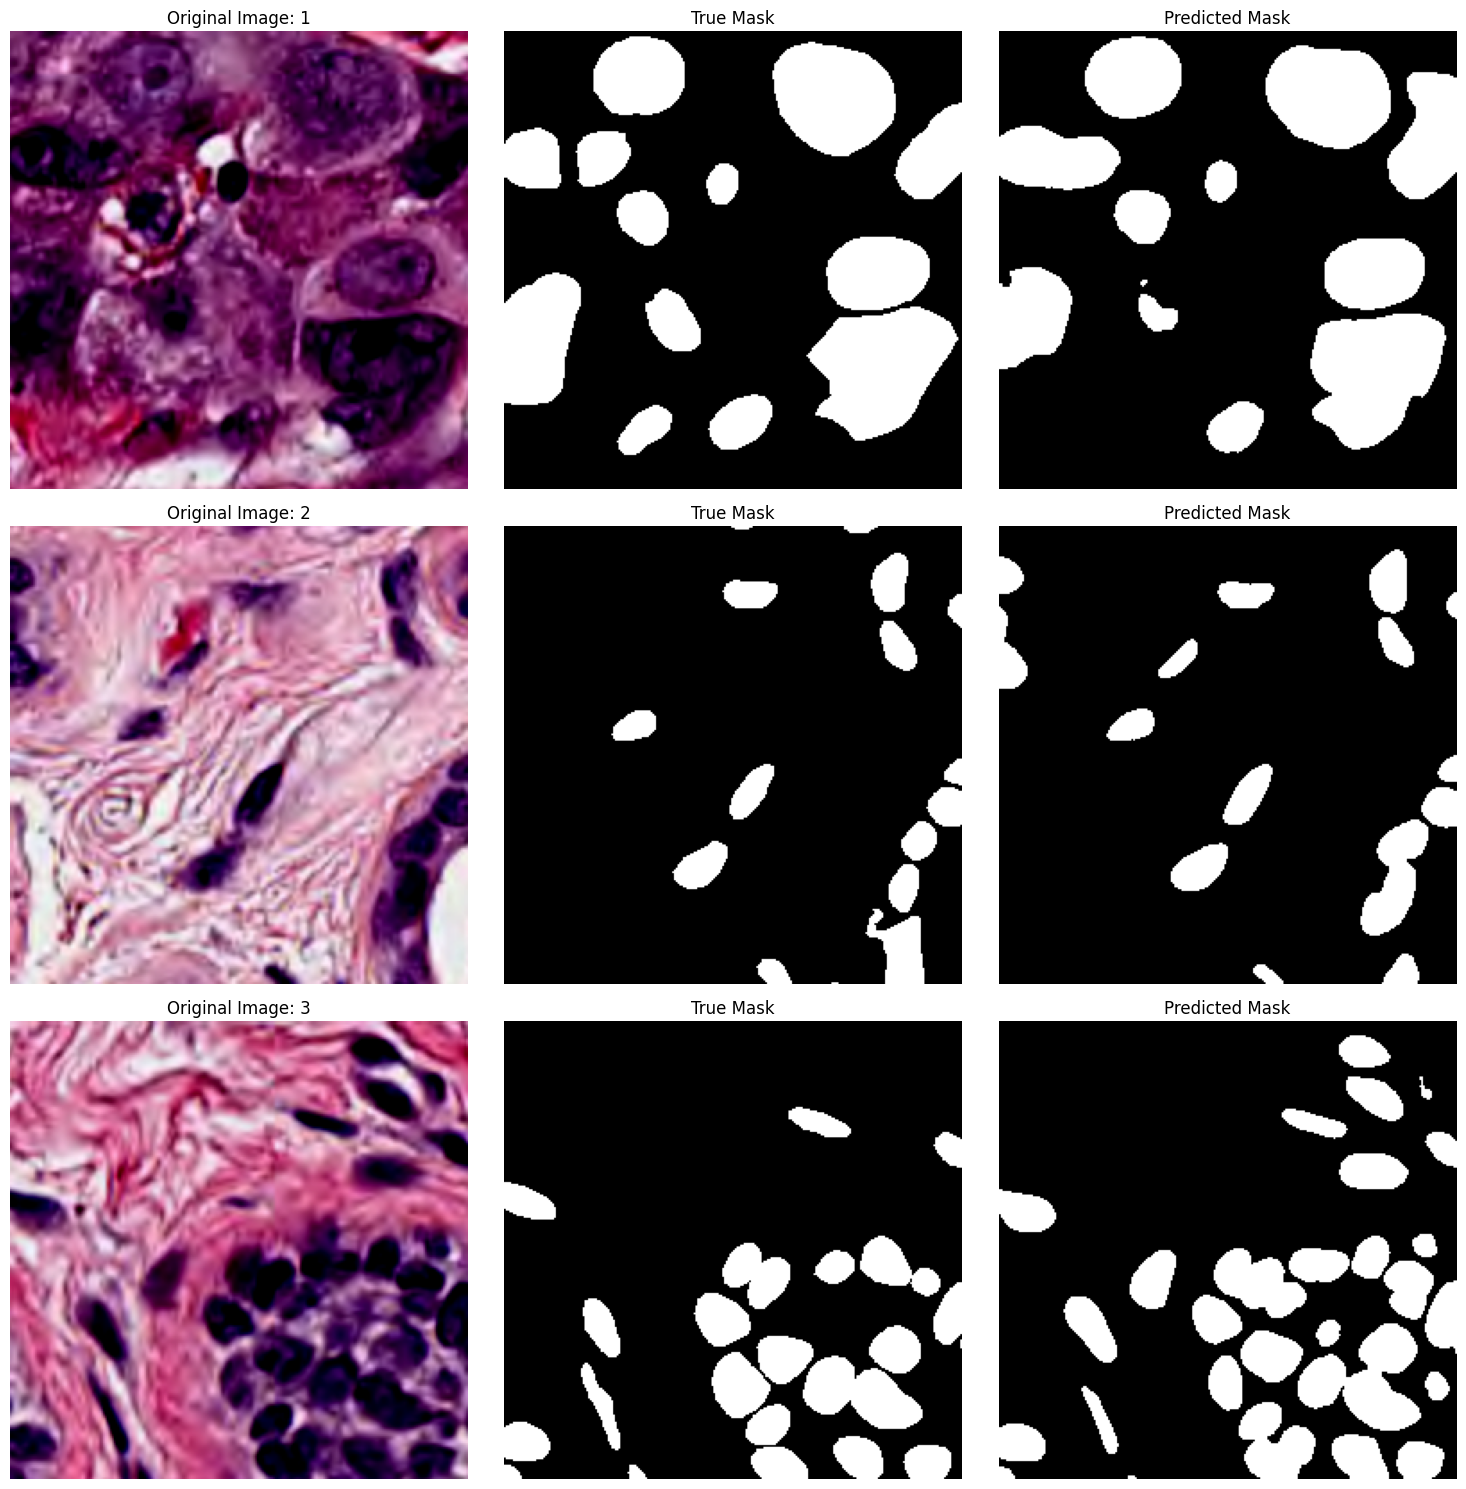

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

def visualize_results(model, dataloader, device, num_samples=3):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            
            # Assume the first item is the image, and the second is a dict containing masks
            if isinstance(batch, (list, tuple)):
                images = batch[0].to(device)
                masks = batch[1]['nuclei_binary_map'].to(device)
            elif isinstance(batch, dict):
                images = batch['image'].to(device)
                masks = batch['nuclei_binary_map'].to(device)
            else:
                raise ValueError("Unexpected batch format")
            
            # Get model prediction
            outputs = model(images)
            pred_masks = outputs['nuclei_binary_map'].argmax(dim=1)
            
            # Move tensors to CPU and convert to numpy for visualization
            image = images[0].cpu().permute(1, 2, 0).numpy()
            true_mask = masks[0].cpu().numpy()
            pred_mask = pred_masks[0].cpu().numpy()
            
            # Use the current iteration number (i+1) as the image number
            image_number = i + 1
            
            axs[i, 0].imshow(image)
            axs[i, 0].set_title(f'Original Image: {image_number}')
            axs[i, 0].axis('off')
            
            axs[i, 1].imshow(true_mask, cmap='gray')
            axs[i, 1].set_title('True Mask')
            axs[i, 1].axis('off')
            
            axs[i, 2].imshow(pred_mask, cmap='gray')
            axs[i, 2].set_title('Predicted Mask')
            axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ensure your model and dataloader are defined
# model should be your trained CellViT model
# dataloader should be your DataLoader for the test set
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the visualization function
visualize_results(model, dataloader, device, num_samples=3)

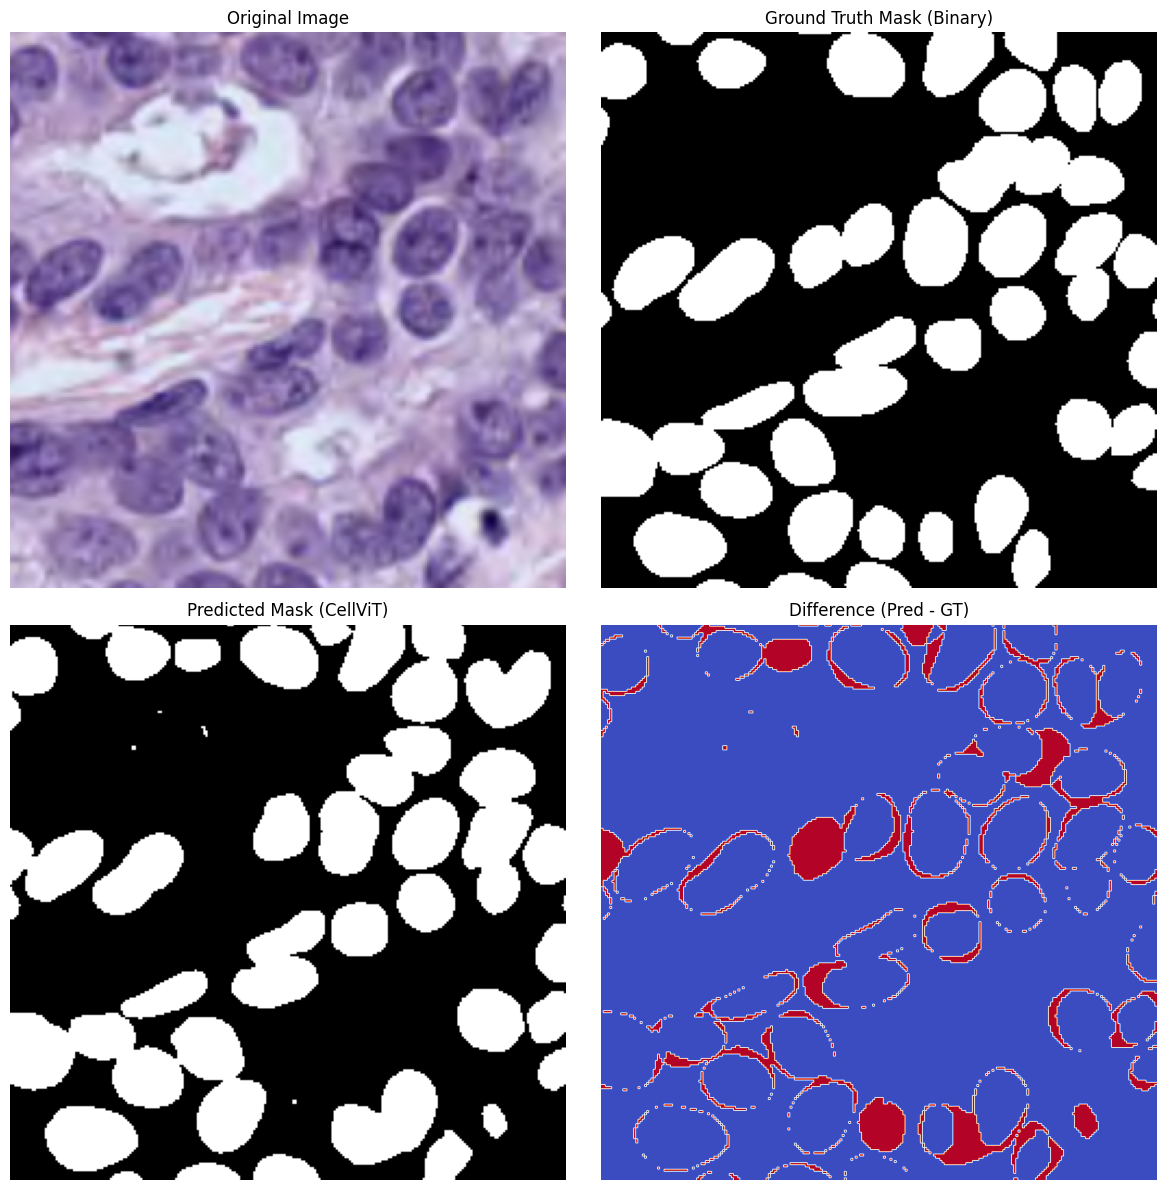

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from skimage.transform import resize

def load_image(image_path):
    img = Image.open(image_path)
    return img

def load_ground_truth(label_path):
    gt_data = np.load(label_path, allow_pickle=True).item()
    gt_mask = gt_data['mask'] if 'mask' in gt_data else next(iter(gt_data.values()))
    gt_mask = np.array(gt_mask)
    # Binarize the ground truth mask
    gt_mask_binary = (gt_mask > 0).astype(np.uint8)
    return gt_mask_binary

def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),  # Adjust size as needed
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return preprocess(image).unsqueeze(0)

def visualize_result(model, image_path, label_path, device):
    model.eval()
    
    # Load and preprocess the image
    original_image = load_image(image_path)
    input_tensor = preprocess_image(original_image).to(device)
    
    # Load and binarize ground truth mask
    gt_mask = load_ground_truth(label_path)
    
    with torch.no_grad():
        # Get model prediction
        outputs = model(input_tensor)
        pred_mask = outputs['nuclei_binary_map'].argmax(dim=1)
    
    # Convert tensor to numpy for visualization
    input_image = input_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Normalize to [0,1]
    pred_mask = pred_mask.cpu().squeeze(0).numpy()
    
    # Resize ground truth mask if shapes don't match
    if gt_mask.shape != pred_mask.shape:
        gt_mask = resize(gt_mask, pred_mask.shape, order=0, preserve_range=True, anti_aliasing=False)
    
    # Calculate difference
    difference = np.abs(pred_mask - gt_mask)
    
    # Visualize
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    
    axs[0, 0].imshow(input_image)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(gt_mask, cmap='gray')
    axs[0, 1].set_title('Ground Truth Mask (Binary)')
    axs[0, 1].axis('off')
    
    axs[1, 0].imshow(pred_mask, cmap='gray')
    axs[1, 0].set_title('Predicted Mask (CellViT)')
    axs[1, 0].axis('off')
    
    axs[1, 1].imshow(difference, cmap='coolwarm', vmin=0, vmax=1)
    axs[1, 1].set_title('Difference (Pred - GT)')
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ensure your model is defined and loaded
# model should be your trained CellViT model

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the base path
base_path = "/rsrch5/home/plm/yshokrollahi/CellViT"


i = 133
# Define the paths
script_path = os.path.join(base_path, "cell_segmentation", "inference")
image_path = os.path.join(base_path, "configs", "datasets", "reassemble", "fold2", "images", f"2_{i}.png")
label_path = os.path.join(base_path, "configs", "datasets", "reassemble", "fold2", "labels", f"2_{i}.npy")

# Ensure the script is run from the correct directory
os.chdir(script_path)

# Check if the files exist
if not os.path.exists(image_path):
    print(f"Error: The image file {image_path} does not exist.")
elif not os.path.exists(label_path):
    print(f"Error: The label file {label_path} does not exist.")
else:
    # Assuming your model is named 'model' and is already loaded
    visualize_result(model, image_path, label_path, device)

In [ ]:
!pwd

/rsrch5/home/plm/yshokrollahi/CellViT/cell_segmentation/inference
